# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: ~~Wednesday, Oct 13, 2021 at 11:59pm~~**
**Updated due date: Friday, Oct 15, 2021 at 11:59pm**


## Imports 

In [39]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [100]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    freq = {0: 0, 1: 0}
    most_freq = -sys.maxsize
    most_freq_class = None

    def fit(self, X, y):
        for i in y:
            self.freq[i]+=1
            if self.freq[i] > self.most_freq:
                self.most_freq = self.freq[i]
                self.most_freq_class = i
        total_examples = self.freq[0] + self.freq[1]
        self.freq[0] /= total_examples
        self.freq[1] /= total_examples
        return None

    def predict(self, X):
        n = X.shape[0]
        res = np.empty(n)
        res.fill(self.most_freq_class)
        return res

    def predict_proba(self, X): # only look at y
        return np.array([*self.freq.values()])

    def score(self, X, y):
        total_examples = X.shape[0]
        correct_pred = 0
        for i in y:
            if i == self.most_freq_class:
                correct_pred += 1
        return correct_pred / total_examples

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [101]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [102]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [103]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [105]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [106]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [107]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [108]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [109]:
# declare a LogisticRegression model on the dataset with max iterations taken for solves to converge at = 1000 
# citation: documentation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#:~:text=max_iterint%2C%20default%3D100,for%20the%20solvers%20to%20converge.
lr = LogisticRegression(max_iter=1000)

# encode text as a sparse matrix of integers, ignoring commonly-used english words that do not add much meaning
countvec = CountVectorizer(stop_words="english")

# transform the text and train a LogisticRegression model on the dataset
pipe = make_pipeline(countvec, lr)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# carry out cross-validation on the training set, passing the split data into the pipeline
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# get the mean cross validation scores calculated during cross-validation
cross_val_results.mean()

fit_time       1.431491
score_time     0.114411
test_score     0.897890
train_score    0.967045
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [211]:
cross_val_results["test_score"]

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64

The 5 scores are quite close to each other, being in the narrow range of 0.896-0.899.

The cities dataset had a lot fewer rows, making it prone to overfitting and less robust. This is confirmed by the fact that the logistic regression model trained on the cities dataset had a lot more variation in the scores (ranging from 0.697 to 0.939). Compared to the scores on the cities dataset, scores from tweets_df are less varied.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [213]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.005493
score_time     0.000925
test_score     0.738675
train_score    0.738675
dtype: float64

- Logistic regression seems to be doing better than the dummy classifier at predicting the sentiment of tweets because its validation scores are higher than that of the dummy classifier.
- It is necessary to use `CountVectorizer` here, because we need to convert a collection of tweets into a matrix of word counts, where each row represents a tweet, and each column represents a unique word. Without splitting each tweet into bag of words representation, each tweet would end up being its own unique category in OHE, and we won't learning anything meaningful.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [216]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [219]:
# The following code is adapted from Lecture 7
viral_probs = pipe.predict_proba(X_test)[:, 1] 
most_likely_viral = np.argmax(viral_probs)
X_test.iloc[most_likely_viral]
# print associated probability

'Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!'

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [118]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [220]:
coefficient_arr = lr_from_pipe.coef_.flatten()
feature_names = vec_from_pipe.get_feature_names()
# Adapted from Lecture 7
data = {
    "coefficient": coefficient_arr,
    "magnitude": np.absolute(coefficient_arr)
}
sorted_coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "coefficient", ascending=False
)
print("5 words with the highest coefficients\n")
print(pd.DataFrame(sorted_coef_df.head(5).iloc[:, 0]))
print("\n5 words with the smallest coefficients\n")
print(pd.DataFrame(sorted_coef_df.tail(5).iloc[:, 0]))

5 words with the highest coefficients

             coefficient
harassment      2.731860
mini            2.712498
fake            2.692708
coronavirus     2.434386
transcripts     2.380507

5 words with the smallest coefficients

                 coefficient
1pic               -2.294926
trump2016          -2.315866
barackobama        -2.565190
trump2016pic       -2.637183
realdonaldtrump    -3.116857


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [144]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [224]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, test_size=0.2, random_state=321) # are we supposed to pass in X_train and y_train into X and y

X_counts_train = countvec.fit_transform(X_train_new)
X_counts_test = countvec.transform(X_test_new)
lr.fit(X_counts_train, y_train_new)
val_score = lr.score(X_counts_test, y_test_new)
print("Test score: %f" % val_score)

Test score: 0.900678


<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

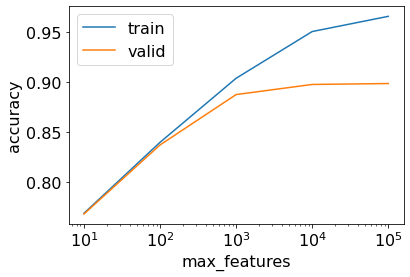

In [147]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [148]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.768346,0.767654
1,100,0.839602,0.836971
2,1000,0.903939,0.887575
3,10000,0.950845,0.897725
4,100000,0.966113,0.898648


A `max_features` value of 10000 seems best for this case. At this value, the model is almost as good as it can get (having a validation score of 0.8977, only 0.001 lower than the validation score at `max_features=100000`) without getting too complex. 
At a higher `max_features` level, we risk overfitting, but at lower levels, we will underfit - so `max_features=10000` would be the best at generalizing to deployment data.

<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

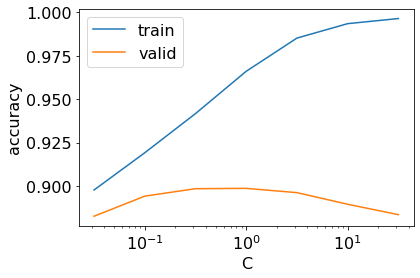

In [150]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [154]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.897689,0.882587
1,0.100000,0.919163,0.894150
2,0.316228,0.941726,0.898446
3,1.000000,0.966113,0.898648
4,3.162278,0.985244,0.896168
5,10.000000,0.993548,0.889478
6,31.622777,0.996497,0.883481


The best `C` is at 1.0, because it is the hyperparameter value that yields the highest validation score. Values greater than 1.0 in this example would lead to overfitting, while values lower than 1.0 would lead to underfitting.

<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [208]:
# Adapted from Lecture 8
param_grid = {
    "countvectorizer__max_features": max_features,
    "logisticregression__C": C_vals,
}
pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000))
grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)
grid_search.fit(X_train, y_train)
print("Best max_features value: %0.1f" % grid_search.best_params_["countvectorizer__max_features"])
print("Best C value: %0.1f" % grid_search.best_params_["logisticregression__C"])

Best max_features value: 100000.0
Best C value: 1.0


<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [210]:
print("Best score: %f" % grid_search.best_score_)
print("Test accuracy: %f" % grid_search.score(X_test, y_test))

Best score: 0.894496
Test accuracy: 0.898858


- The final model with `max_features=100000` and `C=1` yielded a high validation score.
- The test accuracy is actually better than the validation accuracy.
- There is not that big of a difference between the test and validation score - in fact, the test score is higher. This shows that our model generalizes well to deployment data.

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

1. When calling `fit_transform` on test data with `CountVectorizer`, we need to define separate transformers for each column when there's more than one text column, because we are passing a `Series` object into `fit_transform`
2. It's important to not let test or validation data influence the training phase, because since we want to develop a model that generalizes well (has a low test error), if test data contaminates the training phase, our model won't be a good proxy of deployment data and thus would unlikely perform well in production.
3. I would choose `predict_proba`. We would arrive at the same prediction using either `predict` or `predict_proba`, but the latter can give us of a confidence score that inform us of how close the prediction is to the decision boundary.
4. Pipelines can let us chain more than one transformation to our dataset without needing to call `fit_transform` manually for each transformer before passing into the next. It also helps us avoid manually calling `fit_transform` on every training portion and `transform` on every validation fold, reducing the risk of leaking validation data into the train data.
5. `RandomizedSearchCV` is faster compared to `GridSearchCV`, unlike `GridSearchCV`, varying unimportant hyperparameter will not impact the performance of the model score.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 